<img src="NotebookAddons/blackboard-banner.jpg" width="100%" />
<font face="Calibri">
<br>
<font size="7"> <b> GEOS 657: Microwave Remote Sensing <b> </font>

<font size="5"> <b>Lab 6: Volcano Source Modeling Using InSAR <font color='rgba(200,0,0,0.2)'> -- [20 Points] </font> </b> </font>

<br>
<font size="4"> <b> Franz J Meyer; University of Alaska Fairbanks </b> <br>
<font color='rgba(200,0,0,0.2)'> <b>Due Date: </b> April 09, 2019 </font>
</font>

<img style="padding: 7px" src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right" /> <font size="3"> This lab will introduce you to the intersection between Radar Remote Sensing and Inverse Modeling. Radar Remote Sensing can provide us with geodetic observations of surface deformation. Inverse Modeling helps us understand the physical causes behind an observed deformation. 
    
To illuminate the handoff from geodesy to geophysics, this lab will show how to use InSAR observations to determine the most likely parameters of a volcanic magma source underneath Okmok volcano, Alaska. We will use a Mogi source model to describe the physics behind deformation at Okmok. We will again use our **Jupyter Notebook** framework implemented within the Amazon Web Services (AWS) cloud to work on this exercise. <br><br>

This Lab is part of the UAF course <a href="https://radar.community.uaf.edu/" target="_blank">GEOS 657: Microwave Remote Sensing</a>. It will introduce the following data analysis concepts:

- What is a Mogi Source Model describing volcanic source geometry and physics
- How to use the "grid search" method to perform a pseudo-inversion of a Mogi source model 
- How to solve for the best fitting source parameters using modeling with InSAR data
</font>
<br>
<font size="4"> <font color='rgba(200,0,0,0.2)'> <b>THIS NOTEBOOK INCLUDES THREE HOMEWORK ASSIGNMENTS.</b></font> Complete all six assignments to achieve full score. </font> <br>
<font size="3"> The homework assignments in this lab are to be completed within this notebook. To submit your homework, please <font color='rgba(200,0,0,0.2)'> download your completed notebook both asf PDF (*.pdf) and as a Notebook file (*.ipynb) and submit them as a ZIP bundle via Blackboard or email (to fjmeyer@alaska.edu) </font>. To download, please select the following options in the main menu of the notebook interface:

<ol type="1">
  <li><font color='rgba(200,0,0,0.2)'> <b> Save your notebook with all of its content</b></font> by selecting <i> File / Save and Checkpoint </i> </li>
  <li><font color='rgba(200,0,0,0.2)'> <b>To export in Notebook format</b></font>, click on <i>File / Download as / Notebook (.ipynb)</i></li>
  <li><font color='rgba(200,0,0,0.2)'> <b>To export in PDF format</b></font>, click on <i>File / Download as / PDF vs LaTeX (.pdf) </i></li>
</ol>

<b>Please rename the notebooks to include your name before submitting it via Blackboard</b>. Contact me at fjmeyer@alaska.edu should you run into any problems.
</font>

</font>

<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3"> First step in any notebook is to import the required Python libraries into the Jupyter environment. In this notebooks we use the following libraries:
<ol type="1">
    <li> <b><a href="https://pandas.pydata.org/" target="_blank">Pandas</a></b> is a Python library that provides high-level data structures and a vast variety of tools for analysis. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality. </li>
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing.</li>
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays. </li>
    <li> <b><a href="https://matplotlib.org/index.html" target="_blank">Matplotlib</a></b> is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. </li>

</font>

In [1]:
import pandas as pd
import gdal
import numpy as np
import time, os, glob

# Setup plotting inside the notebook
%matplotlib inline
import matplotlib.pylab as plt

<font size="3"> We write a couple of helper functions that check that a given file or path exists. These provide simple error handling for some of our os library function calls:</font>

In [2]:
def fileExists(filename):
    if os.path.isfile(filename):
        return True
    else:
        print("The file " + filename + " is missing.")
        return False

In [3]:
def pathExists(path):
    if os.path.exists(path):
        return True
    else:
        print("Invalid Path.")
        return False

<hr>
<font face="Calibri">

<font size="5"> <b> 1. InSAR at Okmok Volcano, Alaska </b> </font>  

<img style="padding: 7px" src="NotebookAddons/Lab6-OkmokdefoGPS.JPG" width="550" align="right" /><font size="3"> Okmok is one of the more active volcanoes in Alaska’s Aleutian Chain. Its last (known) eruption was in the summer of 2008. Okmok is interesting from an InSAR perspective as it inflates and deflates heavily as magma moves around in its magmatic source located roughly 2.5 km underneath the surface. To learn more about Okmok volcano and its eruptive history, please visit the very informative site of the <a href="https://avo.alaska.edu/volcanoes/activity.php?volcname=Okmok&eruptionid=604&page=basic" target="_blank">Alaska Volcano Observatory</a>.

This lab uses a pair of C-band ERS-2 SAR images acquired on Aug 18, 2000 and Jul 19, 2002 to analyze the properties of a volcanic source that was responsible for an inflation of Okmok volcano of more than 3 cm near its summit. The figure to the right shows the Okmok surface deformation as measured by GPS data from field campaigns conducted in 2000 and 2002. The plots show that the deformation measured at the site is consistent with that created by an inflating point (Mogi) source.<br> 

<b>The primary goal of the problem set is to estimate values for four unknown model parameters describing a source process beneath a volcano.</b> The lab uses real InSAR data from Okmok volcano, so you should get some sense for how remote sensing can be used to infer physical processes at volcanoes. We will assume that the source can be modeled as an inflating point source (a so-called Mogi source; see <a href="https://radar.community.uaf.edu/files/2019/03/2019-Lecture14_UsingInSARinGeophysics.pdf" target="_blank">Lecture 14</a>) and will use a grid-search method for finding the source model parameters (3D source location and volume of magma influx) that best describe our InSAR-observed surface deformation.
</font>
</font>

<hr>
<font face="Calibri" size="5"> <b> 2. Download and Plot the Observed Deformation Map </b>  
    
<font face="Calibri" size="4"> <b> 2.1 Download Data from AWS S3 Storage Bucket</b><br>
<font size="3"> We are using a deformation map created from C-band ERS-2 SAR images acquired on Aug 18, 2000 and Jul 19, 2002. The deformation map is <b>available to you on the Class AWS S3 data storage bucket:</b> </font>

<font face="Calibri" size="3"> Let's create and move to a directory to hold our Lab 6 files:"</font>

In [4]:
!mkdir -p lab_6_data
path = '/home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_6_data'
if pathExists(path):
    os.chdir(path)
print("current directory: " + os.getcwd())

current directory: /home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_6_data


In [5]:
!aws s3 cp s3://asf-jupyter-data/E451_20000818_20020719.unw E451_20000818_20020719.unw

download: s3://asf-jupyter-data/E451_20000818_20020719.unw to ./E451_20000818_20020719.unw


<font face="Calibri" size="3"> The following code cells define some basic variables and then read our data set into the notebook. We will store our observed deformation map in the variable <i>"obs_rngchg"</i>: </font>

In [6]:
#Define some basic variables needed for data analysis
inData='E451_20000818_20020719.unw'
SAMPLE = 1100
LINE = 980
POSTING = 40.0
HALF_WAVE = 28.3

In [7]:
#Read the file into notebook
if fileExists(inData):
    with open (inData, 'rb') as f:    
        coh = np.fromfile(f, dtype='>f', count=-1)
    obs_rngchg=np.reshape(coh,(LINE,SAMPLE))

    #Change unit to [cm] and make sure there are no "NaNs" in the data set
    obs_rngchg = obs_rngchg*HALF_WAVE/2.0/np.pi
    where_are_NaNs = np.isnan(obs_rngchg)
    obs_rngchg[where_are_NaNs] = 0

<font face="Calibri" size="3"> <b>Create a mask</b> that removes invalid samples (low coherence) from the deformation map: </font>

In [8]:
obs_rngchg_m = np.ma.masked_where(obs_rngchg == 0, obs_rngchg)

<hr>
<font face="Calibri" size="4"> <b> 2.2 Visualize The Deformation Map </b>  

<font size="3"> We will visualize the deformation map both in units of [cm] and as a rewrapped interferogram. To do so, we will first <b>write a plotting function</b> that can be reused later: </font>

In [9]:
def extents(f):
        delta = f[1] - f[0]
        return [f[0] - delta/2, f[-1] + delta/2]

In [10]:
def plot_model(infile,line,sample,posting):
    plt.rcParams.update({'font.size': 14})
    xvec = (np.arange(1,sample*posting,posting))/1000
    yvec = (np.arange(1,line*posting,posting))/1000
    inwrapped = ( infile/10 + np.pi) % (2 * np.pi ) - np.pi
    cmap = plt.cm.jet
    cmap.set_bad('white',1.)
    
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1,2,1)
    im = ax1.imshow(infile, interpolation='nearest', cmap=cmap,extent=extents(xvec) + extents(yvec), origin='upper')
    cbar = ax1.figure.colorbar(im, ax=ax1, orientation = 'horizontal')
    ax1.set_title("Displacement in look direction [mm]")
    ax1.set_xlabel("Easting [km]")
    ax1.set_ylabel("Northing [km]")
    plt.grid()
    im.set_clim(-30, 30)
    ax2 = fig.add_subplot(1,2,2)
    im = ax2.imshow(inwrapped, interpolation='nearest', cmap=cmap,extent=extents(xvec) + extents(yvec), origin='upper')
    cbar = ax2.figure.colorbar(im, ax=ax2, orientation = 'horizontal')
    ax2.set_title("Interferogram phase [rad]")
    ax2.set_xlabel("Easting [km]")
    ax2.set_ylabel("Northing [km]")
    plt.grid()

<font face="Calibri" size="3"> Now we can use this function to <b>plot our observed deformation map <i>obs_rngchg</i>:</b> </font>

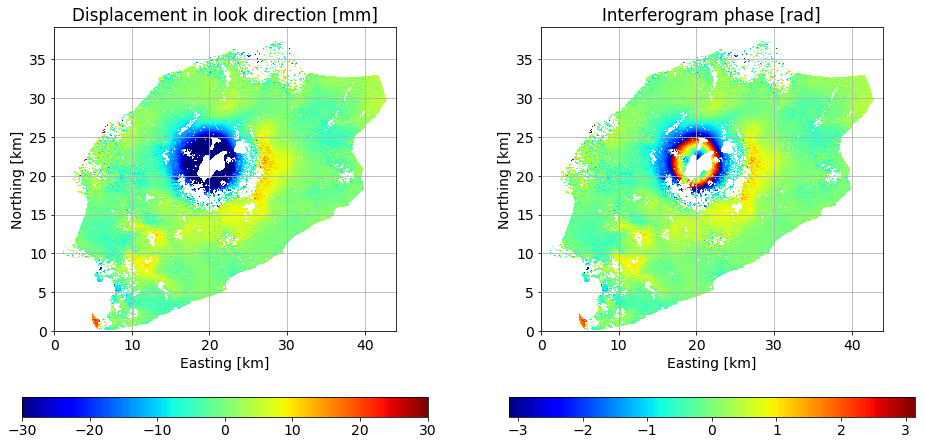

In [11]:
plot_model(obs_rngchg_m,LINE,SAMPLE,POSTING)
plt.savefig('Okmok-inflation-observation.png',dpi=200,transparent='false')

<hr>
<font face="Calibri" size="5"> <b> 3. The Mogi Source Model and InSAR</b>  
    
<font face="Calibri" size="4"> <b> 3.1 The Mogi Equations</b><br>
<font size="3"> The Mogi model provides the 3D ground displacement, $u(x,y,z)$, due to an inflating source at location $(x_s,y_s,z_s)$ with volume change $V$:

\begin{equation}
u(x,y,z)=\frac{1}{\pi}(1-\nu)\cdot V\Big(\frac{x-x_s}{r(x,y,z)^3},\frac{y-y_s}{r(x,y,z)^3},\frac{z-z_s}{r(x,y,z)^3}\Big)
\end{equation}
<br>
\begin{equation}
r(x,y,z)=\sqrt{(x-x_s)^2+(y-y_s)^2+(z-z_s)^2}
\end{equation}

where $r$ is the distance from the Mogi source to $(x,y,z)$, and $\nu$ is the Poisson's ratio of the halfspace. The Poisson ratio describes how rocks react when put under stress (e.g., pressure). It is affected by temperature, the quantity of liquid to solid, and the composition of the soil material. <b>In our problem, we will assume that $\nu$ is fixed</b>. 
 </font>

<hr>
<font face="Calibri" size="4"> <b> 3.2 Projecting Mogi Deformation to InSAR Line-of-Sight</b><br>
<font size="3"> In our example, the $x$-axis points east, $y$ points north, and $z$ points up. However, in the code the input values for $z$ are assumed to be depth, such that the Mogi source is at depth $z_s > 0$. The observed interferogram is already corrected for the effect of topography, so the observations can be considered to be at $z = 0$.
    
<img style="padding: 7px" src="NotebookAddons/Lab6-LOSprojection.JPG" width="650" align="center" />
The satellite “sees” a projection of the 3D ground displacement, $u$, onto the look vector, $\hat{L}$, which points from the satellite to the target. Therefore, we are actually interested in the (signed magnitude of the) projection of $u$ onto $\hat{L}$ (right). This is given by

\begin{array}{lcl} proj_{\hat{L}}u & = & (u^T\hat{L})\hat{L} \\ u^T\hat{L} & = & u \cdot \hat{L} = |u||\hat{L}|cos(\alpha) = |u|cos(\alpha) \\ & = & u_x\hat{L}_x+ u_y\hat{L}_y + u_z\hat{L}_z \end{array}

where the look vector is given by $\hat{L}=(sin(l) \cdot cos(t), -sin(l) \cdot sin(t), -cos(l))$, where $l$ is the look angle measured from the nadir direction and $t$ is the satellite track angle measured clockwise from geographic north. All vectors are represented in an east-north-up basis.

Our forward model takes a Mogi source, $(x_s,y_s,z_s,V)$, and computes the look displacement at any given $(x, y, z)$ point. If we represent the <i>i</i>th point on our surface grid by $x_i = (x_i,y_i,z_i)$ the the displacement vector is $u_i = u(x_i, y_i, z_i)$, and the look displacement is

\begin{equation}
d_i = u_i \cdot \hat{L}
\end{equation}

<br>
<hr>
<font size="4"> <b> 3.3 Defining the Mogi Forward Model</b><br></font>
<font size="3">We can now represent the Mogi <i>forward problem</i> as 

\begin{equation}
g(m) = d
\end{equation}

where $g(·)$ describes the forward model in the very first equation in this notebook, $m$ is the (unknown) Mogi model, and $d$ is the predicted interferogram. The following code cells calculate the Mogi forward model according to the equations given above:

</font>


In [12]:
# function to calculate forward model for a Mogi source
def rngchn_mogi(n1,e1,depth,del_v,ning,eing,plook):
    
    # This geophysical coefficient is needed to describe how pressure relates to volume change
    dsp_coef = (1e6*del_v*3)/(np.pi*4)
    
    # Calculating the horizontal distance from every point in the deformation map to the x/y source location
    d_mat = np.sqrt(np.square(ning-n1) + np.square(eing-e1))
    
    # denominator of displacement field for mogi source
    tmp_hyp = np.power(np.square(d_mat) + np.square(depth),1.5)
    
    # horizontal displacement
    del_d = dsp_coef*d_mat/tmp_hyp
    
    # vertical displacement
    del_f = dsp_coef*depth/tmp_hyp
    
    # azimuthal angle
    azim = np.arctan2((eing-e1),(ning-n1))
    
    # compute north and east displacement from horizontal displacement and azimuth angle
    e_disp = np.sin(azim)*del_d
    n_disp = np.cos(azim)*del_d
    
    # project displacement field onto look vector
    temp = np.concatenate((e_disp,n_disp,del_f),axis=1)
    del_rng = temp.dot(np.transpose([plook]))
    del_rng = -1.0*del_rng
    return del_rng

In [13]:
# Function to create simulated deformation data based on Mogi Source Model parameters
def mogi2insar(x,y,z,v,iplot,imask):
    # Organizing model parameters
    bvc = [x, y, z, v, 0, 0, 0, 0]
    bvc = np.transpose(bvc)
    
    # Setting acquisition parameters
    track =  -13.3*np.pi/180.0
    look  = 23.0*np.pi/180.0
    SAMPLE = 1100
    LINE = 980
    POSTING = 40
    plook = [-np.sin(look)*np.cos(track), np.sin(look)*np.sin(track), np.cos(look)]
    m = LINE
    n = SAMPLE
    
    # Defining easting and northing vectors
    ning = np.arange(0,(m)*POSTING,POSTING)/1000
    eing = np.arange(0,(n)*POSTING,POSTING)/1000
    ning_mat=np.tile(ning,(n,1))
    eing_mat=np.transpose(np.tile(eing,(m,1)))
    ning_vec = np.reshape(ning_mat, (m*n,1))
    eing_vec = np.reshape(eing_mat, (m*n,1))
    
    # Handing coordinates and model parameters over to the rngchg_mogi function
    calc_rng = rngchn_mogi(bvc[1],bvc[0],bvc[2],bvc[3],ning_vec,eing_vec,plook)
    
    # Reshaping surface deformation data derived via rngchg_mogi
    calc_mat = np.reshape(calc_rng, (n,m))
    #print(calc_mat.shape)
    calc_mat_rot = np.transpose(np.fliplr(calc_mat))
    #print(calc_mat_rot.shape)
    
    return calc_mat_rot

<hr>
<font face="Calibri" size="4"> <b> 3.4 Plotting The Mogi Forward Model</b><br></font>
<font face="Calibri" size="3">The cell below plots several Mogi forward models by varying some of the four main Mogi modeling parameters $(x_s,y_s,z_s,V)$.
    
The examples below fix the <i>depth</i> parameter to $z_s = 2.58 km$ and the <i>volume</i> change parameter to $V = 0.0034 km^3$. We then vary the <i>easting</i> and <i>northing</i> parameters $x_s$ and $y_s$ to demonstrate how the model predictions vary when model parameters are changed: 

</font>

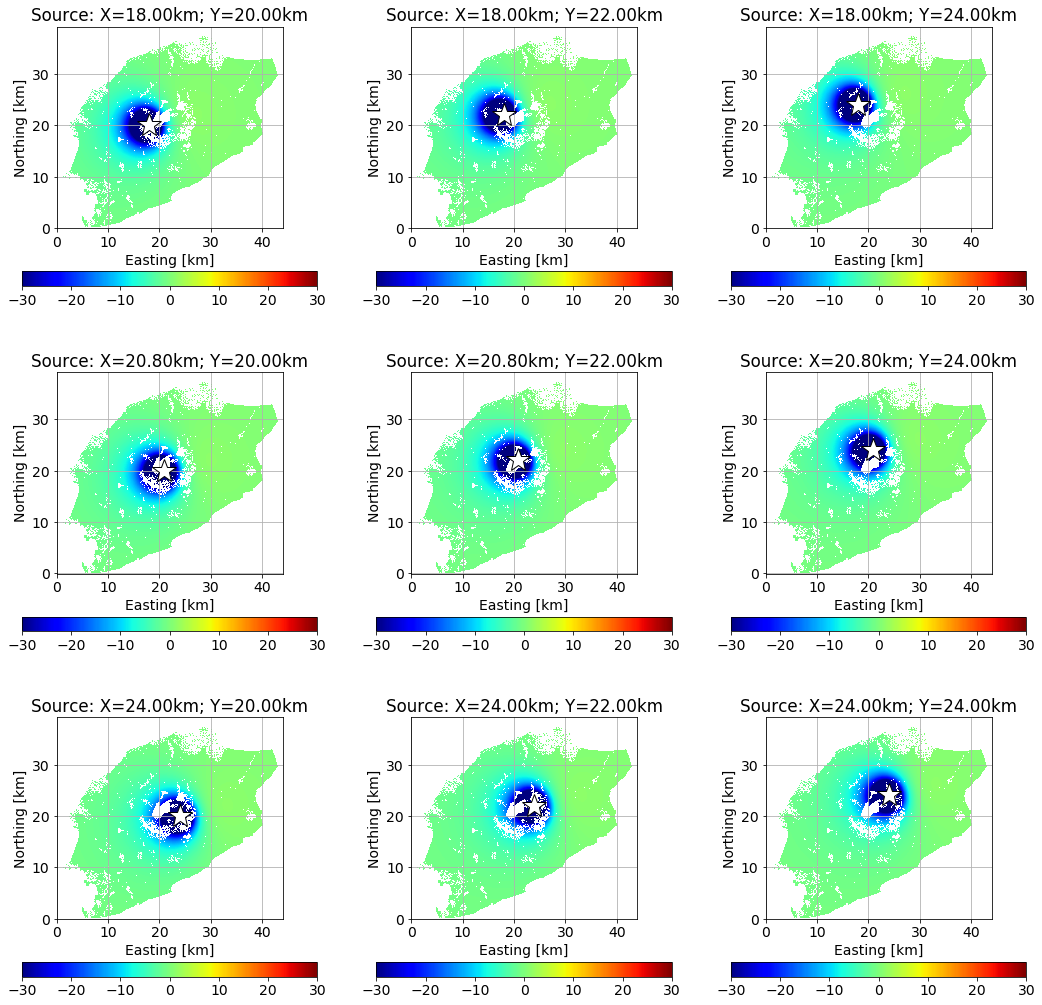

In [14]:
plt.rcParams.update({'font.size': 14})
xvec = (np.arange(1,SAMPLE*POSTING,POSTING))/1000
yvec = (np.arange(1,LINE*POSTING,POSTING))/1000
xs = np.arange(18,24.2,0.4)
ys = np.arange(20,24.2,0.4)

zs = 2.5;
V = 0.0034;
xa = [0, 7, 15]
ya = [0 ,5, 10]

fig = plt.figure(figsize=(18, 18))
cmap = plt.cm.jet
kk = 1

for k in xa:
    for l in ya: 
        ax = fig.add_subplot(3,3,kk)
        syn_rngchg = mogi2insar(xs[k],ys[l],zs,V,0,0)
        syn_rngchg_m = np.ma.masked_where(obs_rngchg == 0, syn_rngchg)
        im = ax.imshow(syn_rngchg_m, cmap=cmap,extent=extents(xvec) + extents(yvec))
        cbar = ax.figure.colorbar(im, ax=ax, orientation = 'horizontal')
        plt.grid()
        im.set_clim(-30, 30)
        ax.plot(xs[k],ys[l], 'k*',markersize=25, markerfacecolor='w')
        ax.set_title('Source: X=%4.2fkm; Y=%4.2fkm' % (xs[k],ys[l]))
        ax.set_xlabel("Easting [km]")
        ax.set_ylabel("Northing [km]")
        kk = kk+1
        
plt.savefig('Model-samples-3by3.png',dpi=200,transparent='false')

<br>
<hr>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT #1</u>:  </font> Experiment with the Mogi Forward Model </b> <font color='rgba(200,0,0,0.2)'> -- [8 Points] </font> </font>

<font face="Calibri" size="3"> To get a feeling for the Mogi forward model, please run the following forward model experiments using the Python Function <i>mogi2insar</i> and plot the results (using the code cell above):

<ol type="a">
<li>Run a reference simulation using the code cell above by specifying the following model parameters for source depth $x_s$ and volume change $V$: $z_{s1} = 2.5 km$; $V_1 = 0.01 km^3$. The script will visualize the resulting simulated surface deformation maps. Change the name of the output figure (last line of the script) to something that you will recognize later on (e.g., ReferenceRun.png).<font color='rgba(200,0,0,0.2)'> -- [2 Points] </font></li>
<br>
<li>Change the depth of the source by a factor of three ($z_{s2} = 7.5 km$) while leaving the other model parameters unchanged. Modify name of the output figure in the last line of the script. Visualize the results. Discuss changes to the reference run. Describe how the strength and shape of the deformation signal has changed and provide a physical explanation.<font color='rgba(200,0,0,0.2)'> -- [2 Points] </font></li>
<br>
<li>Now change the source volume by a factor of three ($V_2 = 0.03 km^3$ – also reset source depth to $z_{s1} = 2.5 km$). Visualize the results and compare them to the reference run.<font color='rgba(200,0,0,0.2)'> -- [2 Points] </font></li>
<br>
<li>Finally change both source volume and depth by a factor of three ($z_{s2} = 7.5 km$ and $V_2 = 0.03 km^3$). Compare this result to the results of experiments 1–3.<font color='rgba(200,0,0,0.2)'> -- [2 Points] </font></li>
</ol>

</font>
</div>

<hr>
<div class="alert alert-success">
<font face="Calibri" size="3"> <i><font color='rgba(200,0,0,0.2)'> Question 1.1 [2 Points]:</font> Experiment no. 1: Perform reference run in code cell above using source model parameters to $z_{s1} = 2.5 km$; $V_1 = 0.01 km^3$. Plot results.</i> 

ADD DISCUSSION HERE:
</font>
</div>

<hr>
<div class="alert alert-success">
<font face="Calibri" size="3"> <i><font color='rgba(200,0,0,0.2)'> Question 1.2 [2 Points]:</font> Experiment no. 2: Set source model parameters to $z_{s2} = 7.5 km$; $V_1 = 0.01 km^3$. Plot and discuss the results in comparison to reference run.</i> 

ADD DISCUSSION HERE:
</font>
</div>

<hr>
<div class="alert alert-success">
<font face="Calibri" size="3"> <i><font color='rgba(200,0,0,0.2)'> Question 1.3 [2 Points]:</font> Experiment no. 3: Set source model parameters to $V_2 = 0.03 km^3$ and $z_{s1} = 2.5 km$. Plot and discuss the results in comparison to reference run.</i> 

ADD DISCUSSION HERE:
</font>
</div>

<hr>
<div class="alert alert-success">
<font face="Calibri" size="3"> <i><font color='rgba(200,0,0,0.2)'> Question 1.4 [2 Points]:</font> Experiment no. 4: Set source model parameters to $V_2 = 0.03 km^3$ and $z_{s2} = 7.5 km$. Plot and discuss the results in comparison to reference run.</i> 

ADD DISCUSSION HERE:
</font>
</div>
<hr>

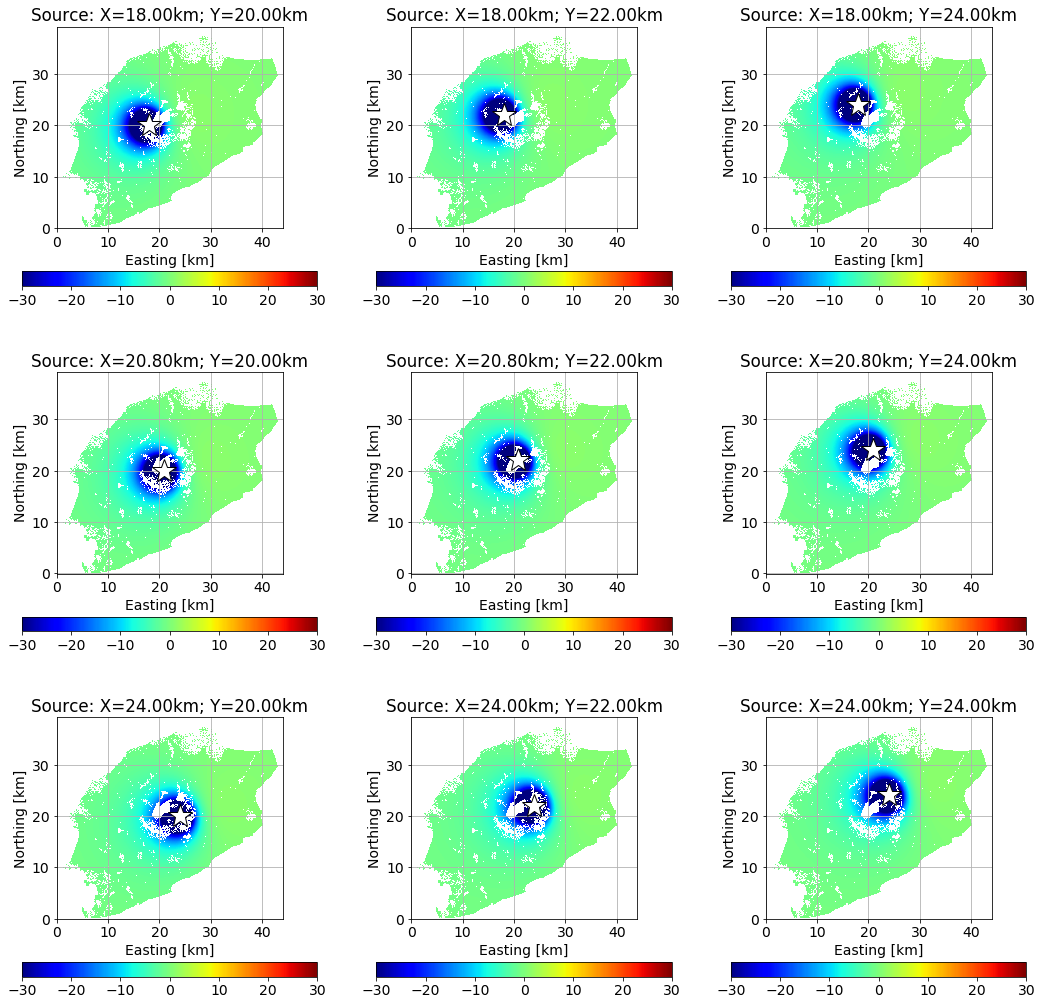

In [15]:
# --- MODIFY THIS SCRIPT TO ANSWER THE QUESTIONS 1.2 - 1.4 --- #
plt.rcParams.update({'font.size': 14})
xvec = (np.arange(1,SAMPLE*POSTING,POSTING))/1000
yvec = (np.arange(1,LINE*POSTING,POSTING))/1000
xs = np.arange(18,24.2,0.4)
ys = np.arange(20,24.2,0.4)

# ------------ Change Variable HERE --------------- #
zs = 2.58;
V = 0.0034;
# ------------------------------------------------- #

xa = [0, 7, 15]
ya = [0 ,5, 10]

fig = plt.figure(figsize=(18, 18))
cmap = plt.cm.jet
kk = 1

for k in xa:
    for l in ya: 
        ax = fig.add_subplot(3,3,kk)
        syn_rngchg = mogi2insar(xs[k],ys[l],zs,V,0,0)
        syn_rngchg_m = np.ma.masked_where(obs_rngchg == 0, syn_rngchg)
        im = ax.imshow(syn_rngchg_m, cmap=cmap,extent=extents(xvec) + extents(yvec))
        cbar = ax.figure.colorbar(im, ax=ax, orientation = 'horizontal')
        plt.grid()
        im.set_clim(-30, 30)
        ax.plot(xs[k],ys[l], 'k*',markersize=25, markerfacecolor='w')
        ax.set_title('Source: X=%4.2fkm; Y=%4.2fkm' % (xs[k],ys[l]))
        ax.set_xlabel("Easting [km]")
        ax.set_ylabel("Northing [km]")
        kk = kk+1

# CHANGE THE NAME OF THE IMAGE THAT IS BEING SAVED TO YOUR CLOUD INSTANCE!!
plt.savefig('Model-samples-3by3.png',dpi=200,transparent='false')

<hr>
<font face="Calibri" size="5"> <b> 4. Solving the [Pseudo]-Inverse Model</b><br></font>
<font face="Calibri" size="3"> The inverse problem seeks to determine the optimal parameters $(\hat{x_s},\hat{y_s},\hat{z_s},\hat{V})$ of the Mogi model $m$ by minimizing the <i>misfit</i> between predictions, $g(m)$, and observations $d^{obs}$ according to
    
\begin{equation}
\sum{\Big[g(m) - d^{obs}\Big]^2}
\end{equation}

This equation describes misfit using the <i>method of least-squares</i>, a standard approach to approximate the solution of an overdetermined equation system. We will use a <i>grid-search</i> approach to find the set of model parameters that minimize the the misfit function. The approach is composed of the following processing steps: 
<ol>
<li>Loop through the mogi model parameters,</li> 
<li>Calculate the forward model for each set of parameters,</li> 
<li>Calculate the misfit $\sum{[g(m) - d^{obs}]^2}$, and</li> 
<li>Find the parameter set that minimizes this misfit.</li>
</ol>
</font>

<hr>
<font face="Calibri" size="4"> <b> 4.1 Experimenting with Misfit</b><br></font>
<font face="Calibri" size="3">Let's look at the misfit $\sum{[g(m) - d^{obs}]^2}$ for a number of different model parameter sets $(x_s,y_s,z_s,V)$: 

</font>

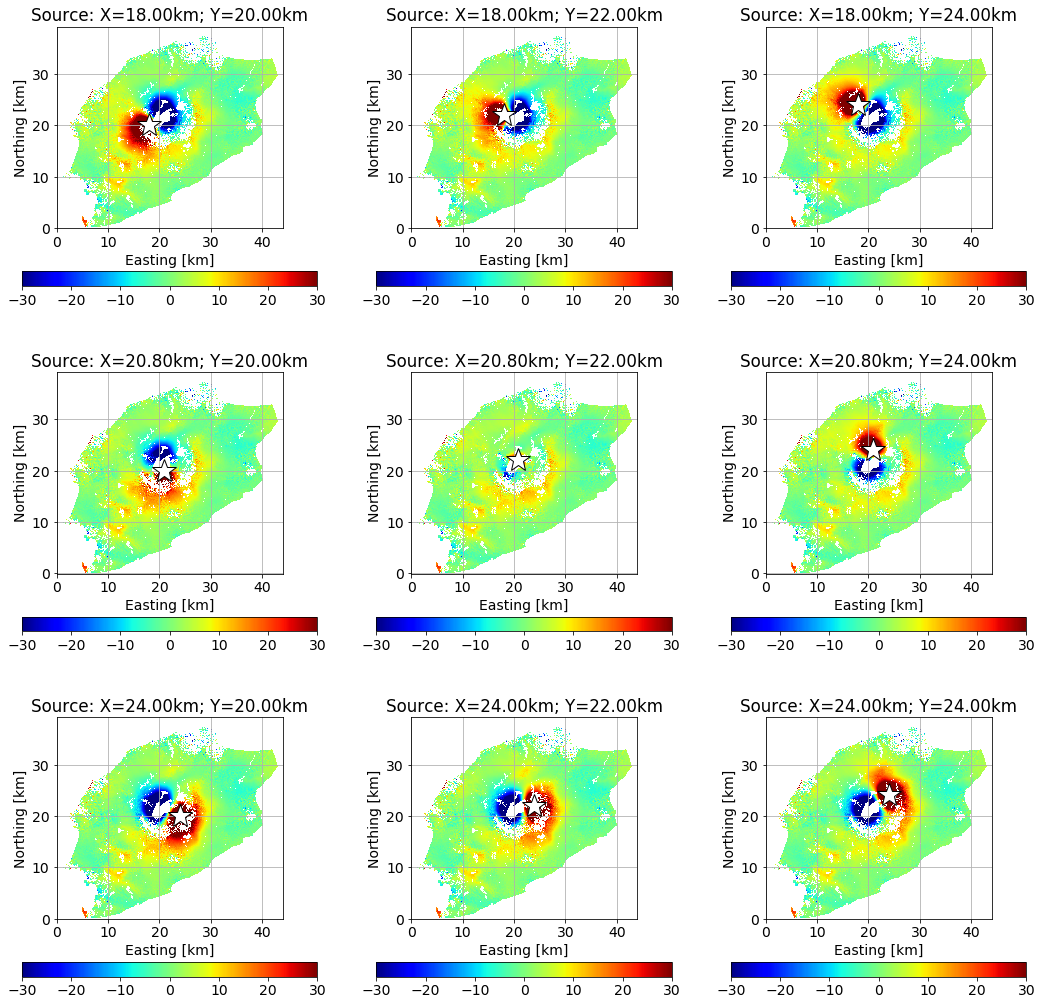

In [16]:
plt.rcParams.update({'font.size': 14})
xvec = (np.arange(1,SAMPLE*POSTING,POSTING))/1000
yvec = (np.arange(1,LINE*POSTING,POSTING))/1000
xs = np.arange(18,24.2,0.4)
ys = np.arange(20,24.2,0.4)

zs = 2.5;
V = 0.0034;
xa = [0, 7, 15]
ya = [0 ,5, 10]

fig = plt.figure(figsize=(18, 18))
cmap = plt.cm.jet
kk = 1

for k in xa:
    for l in ya: 
        ax = fig.add_subplot(3,3,kk)
        syn_rngchg = mogi2insar(xs[k],ys[l],zs,V,0,0)
        syn_rngchg_m = np.ma.masked_where(obs_rngchg == 0, syn_rngchg)
        im = ax.imshow(obs_rngchg_m-syn_rngchg_m, cmap=cmap,extent=extents(xvec) + extents(yvec))
        cbar = ax.figure.colorbar(im, ax=ax, orientation = 'horizontal')
        plt.grid()
        im.set_clim(-30, 30)
        ax.plot(xs[k],ys[l], 'k*',markersize=25, markerfacecolor='w')
        ax.set_title('Source: X=%4.2fkm; Y=%4.2fkm' % (xs[k],ys[l]))
        ax.set_xlabel("Easting [km]")
        ax.set_ylabel("Northing [km]")
        kk = kk+1
plt.savefig('Misfit-samples-3by3.png',dpi=200,transparent='false')

<hr>
<font face="Calibri" size="4"> <b> 4.2 Running Grid-Search to Find Best Fitting Model Parameters $(\hat{x}_s,\hat{y}_s)$</b><br></font>
<font face="Calibri" size="3">The following code cell runs a grid-search approach to find the best fitting Mogi source parameters for the 2000-2002 deformation event at Okmok. To keep things simple, we will fix the depth $z_s$ and volume change $V$ parameters close to their "true" values and search only for the correct east/north source location ($x_s,y_s$).
    
The following code cell demonstrates how to script the grid-search approach in Python:
</font>

In [17]:
# FIX Z AND dV, SEARCH OVER X AND Y

# Setting up search parameters
xs = np.arange(19,22.2,0.2)
ys = np.arange(21,23.2,0.2)
zs = 2.58;
V = 0.0034;

nx = xs.size
ny = ys.size
ng = nx*ny;

print('fixed z = ',zs,' km, dV = ',V, ' searching over (x,y)')

misfit=np.zeros((nx,ny))
kk = 0

# Commence grid-search for best model parameters
for k, xv in enumerate(xs):
    for l, yv in enumerate(ys):
        kk = kk+1
        syn_rngchg = mogi2insar(xs[k],ys[l],zs,V,0,0)
        syn_rngchg_m = np.ma.masked_where(obs_rngchg == 0, syn_rngchg)
        misfit[k,l] = np.sum(np.square(obs_rngchg_m - syn_rngchg_m))
    print('Source %3d/%3d is x = %4.2f km, y = %4.2f km' % (kk, ng, xs[k], ys[l]))


# Searching for the minimum in the misfit matrix
mmf = np.where(misfit == np.min(misfit))
print('')
print('----------------------------------------------------------------')
print('Best fitting Mogi Source located at: X = %5.2f km; Y = %5.2f km' % (xs[mmf[0]], ys[mmf[1]]))
print('----------------------------------------------------------------')

fixed z =  2.58  km, dV =  0.0034  searching over (x,y)
Source  11/176 is x = 19.00 km, y = 23.00 km
Source  22/176 is x = 19.20 km, y = 23.00 km
Source  33/176 is x = 19.40 km, y = 23.00 km
Source  44/176 is x = 19.60 km, y = 23.00 km
Source  55/176 is x = 19.80 km, y = 23.00 km
Source  66/176 is x = 20.00 km, y = 23.00 km
Source  77/176 is x = 20.20 km, y = 23.00 km
Source  88/176 is x = 20.40 km, y = 23.00 km
Source  99/176 is x = 20.60 km, y = 23.00 km
Source 110/176 is x = 20.80 km, y = 23.00 km
Source 121/176 is x = 21.00 km, y = 23.00 km
Source 132/176 is x = 21.20 km, y = 23.00 km
Source 143/176 is x = 21.40 km, y = 23.00 km
Source 154/176 is x = 21.60 km, y = 23.00 km
Source 165/176 is x = 21.80 km, y = 23.00 km
Source 176/176 is x = 22.00 km, y = 23.00 km

----------------------------------------------------------------
Best fitting Mogi Source located at: X = 20.60 km; Y = 21.80 km
----------------------------------------------------------------


<hr>
<font face="Calibri" size="4"> <b> 4.3 Plot and Inspect the Misfit Function</b><br></font>
<font face="Calibri" size="3">The code cell below plots the misfit function ($\sum{[g(m) - d^{obs}]^2}$) describing the fit of different Mogi source parameterizations to the observed InSAR data. You should notice a clear minimum in the misfit plot at the location of the best fitting source location estimated above. 
    
You may notice that, even for the best fitting solution, the misfit does not become zero. This could be due to other signals in the InSAR data (e.g., atmospheric effects or residual topography). Alternatively, it could also indicate that the observed deformation doesn't fully comply with Mogi theory. 
</font>

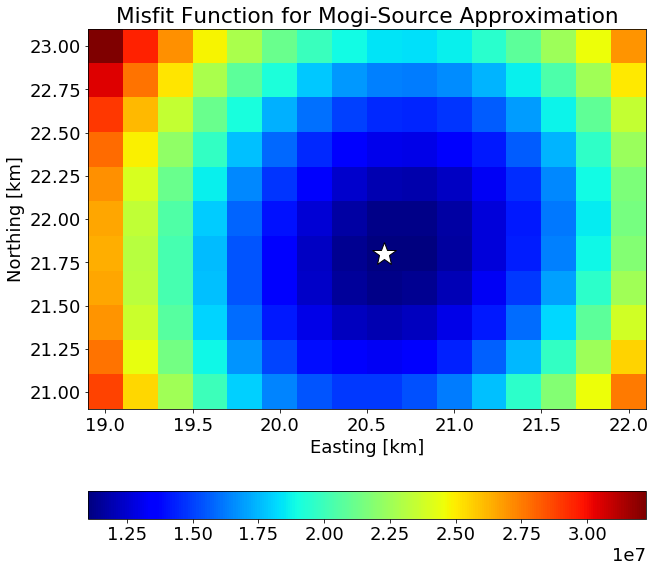

In [18]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(10, 10))
cmap = plt.cm.jet
ax1 = fig.add_subplot(1,1,1)
im = ax1.imshow(np.transpose(misfit), origin='lower', cmap=cmap,extent=extents(xs) + extents(ys))
# USE THIS COMMAND TO CHANGE COLOR SCALING: im.set_clim(-30, 30)
ax1.set_aspect('auto')
cbar = ax1.figure.colorbar(im, ax=ax1, orientation = 'horizontal')
ax1.plot(xs[mmf[0]], ys[mmf[1]], 'k*',markersize=25, markerfacecolor='w')
ax1.set_title("Misfit Function for Mogi-Source Approximation")
ax1.set_xlabel("Easting [km]")
ax1.set_ylabel("Northing [km]")
plt.savefig('Misfit-function.png',dpi=200,transparent='false')

<hr>
<font face="Calibri" size="4"> <b> 4.4 Plot Best-Fitting Mogi Forward Model and Compare to Observations</b><br></font>
<font face="Calibri" size="3">With the best-fitting model parameters defined, you can now analyze how well the model fits the InSAR-observed surface deformation. The best way to do that is to look at both the observed (<i>obs_rngchg</i>) and predicted (<i>syn_rngchg</i>) deformation maps and compare their spatial patterns. Additionally, we will also plot the residuals (<i>obs_rngchg</i> - <i>obs_rngchg</i>) to determine if there are additional signals in the data that are not modeled using Mogi theory. 
</font>

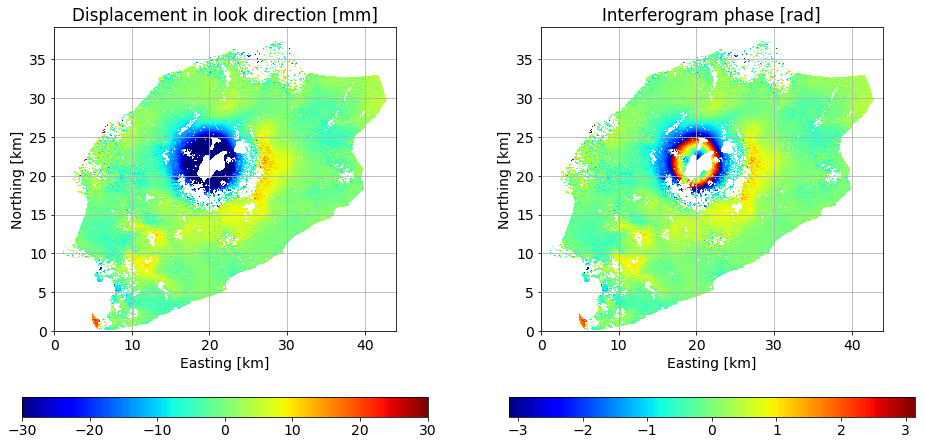

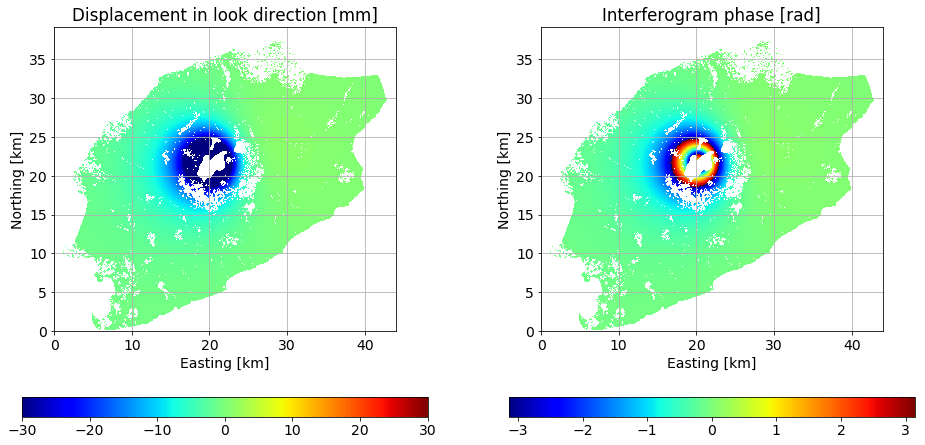

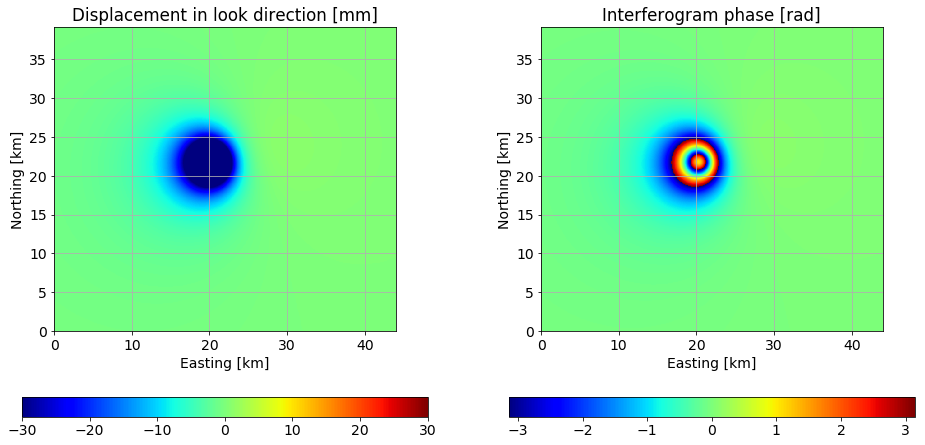

In [20]:
# Calculate predicted deformation map for best-fitting Mogi parameters:
syn_rngchg = mogi2insar(xs[mmf[0]],ys[mmf[1]],zs,V,0,0)

# Mask the predicted deformation map to remove pixels incoherent in the observations:
syn_rngchg_m = np.ma.masked_where(obs_rngchg == 0, syn_rngchg)

# Plot observed deformation map
plot_model(obs_rngchg_m,LINE,SAMPLE,POSTING)

# Plot simulated deformation map
plot_model(syn_rngchg_m,LINE,SAMPLE,POSTING)

plt.savefig('BestFittingMogiDefo.png',dpi=200,transparent='false')

# Plot simulated deformation map without mask applied
plot_model(syn_rngchg,LINE,SAMPLE,POSTING)

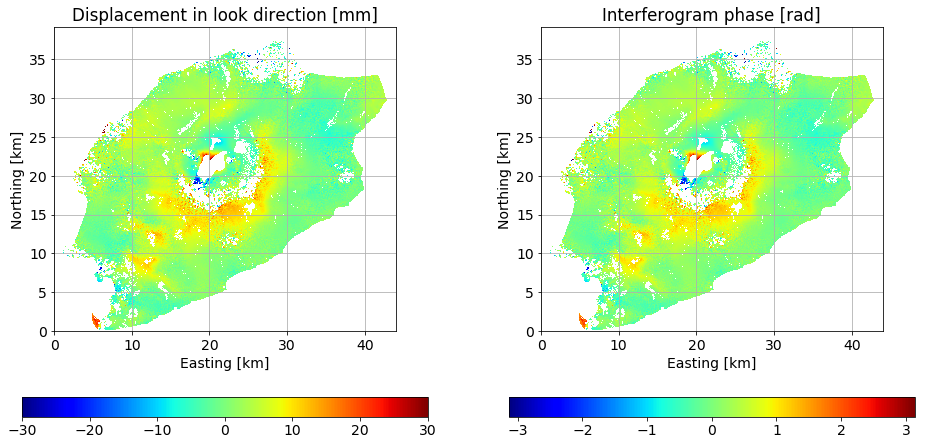

In [21]:
# Plot residual between observed and predicted deformation maps
plot_model(obs_rngchg_m-syn_rngchg_m,LINE,SAMPLE,POSTING)
plt.savefig('Residuals-ObsMinusMogi.png',dpi=200,transparent='false')

<br>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT #2</u>:  </font> Run 2nd Grid-Search to Find Model Parameters $(\hat{z}_s,\hat{V})$  </b> <font color='rgba(200,0,0,0.2)'> -- [8 Points] </font> </font>

<font face="Calibri" size="3"> For this second grid-search run, we now switch out the model parameters we are trying to estimate. We will assume that the lateral location of the Mogi source is now fixed to its estimated value ($\hat{x}_s = 20.6 km$; $\hat{y}_s = 21.8 km$). 

<u>To perform a grid search for the best fitting model parameters $\hat{z}_s$ and $\hat{V}$this exercise, please complete the following steps</u>:

<ol>
<br>
<li>Using the previous grid-search script as a template, <b>write a new grid-search script to search for the best fitting source model depth ($z_s$) and volume change ($V$)</b>.<font color='rgba(200,0,0,0.2)'> -- [3 Points] </font></li>
<br>
<li>Provide a plot of the misfit function and provide the best-fitting values for $\hat{z}_s$ and $\hat{V}$. When plotting the misfit function, put $z_s$ on the vertical axis. You may want to adjust the color scale, in order to better see the shape of the misfit function.<font color='rgba(200,0,0,0.2)'> -- [2 Points] </font></li>
<br>
<li>Compare the $z_s$ vs $V$ misfit function (misfit function 2) to the $y_s$ vs $x_s$ misfit function (misfit function 1). You should see that the shape of the function is different. Misfit function 1 is largely of circular shape while misfit function 2 appears elongated. Interpret this pattern.<font color='rgba(200,0,0,0.2)'> -- [3 Points] </font></li>
</ol>

</font>
</div>

<hr>
<div class="alert alert-success">
<font face="Calibri" size="3"> <i><font color='rgba(200,0,0,0.2)'> Question 2.1 [3 Points]:</font> Provide code to perform grid search over $z_s$ and $V$.</i> 

PROVIDE SCRIPT BY MODIFYING THE CODE IN THE CODE CELL BELOW:
</font>
</div>

In [22]:
# !!!! MODIFY THIS SCRIPT TO PERFORM A GRID SEARCH OVER zs AND V: !!!!

# Setting up search parameters
xs = np.arange(19,22.2,0.2)
ys = np.arange(21,23.2,0.2)
zs = 2.58;
V = 0.0034;

nx = xs.size
ny = ys.size
ng = nx*ny;

print('fixed z = ',zs,' km, dV = ',V, ' searching over (x,y)')

misfit=np.zeros((nx,ny))
kk = 0

# Commence grid-search for best model parameters
for k, xv in enumerate(xs):
    for l, yv in enumerate(ys):
        kk = kk+1
        syn_rngchg = mogi2insar(xs[k],ys[l],zs,V,0,0)
        syn_rngchg_m = np.ma.masked_where(obs_rngchg == 0, syn_rngchg)
        misfit[k,l] = np.sum(np.square(obs_rngchg_m - syn_rngchg_m))
    print('Source %3d/%3d is x = %4.2f km, y = %4.2f km' % (kk, ng, xs[k], ys[l]))


# Searching for the minimum in the misfit matrix
mmf = np.where(misfit == np.min(misfit))
print('')
print('----------------------------------------------------------------')
print('Best fitting Mogi Source located at: X = %5.2f km; Y = %5.2f km' % (xs[mmf[0]], ys[mmf[1]]))
print('----------------------------------------------------------------')

fixed z =  2.58  km, dV =  0.0034  searching over (x,y)
Source  11/176 is x = 19.00 km, y = 23.00 km
Source  22/176 is x = 19.20 km, y = 23.00 km
Source  33/176 is x = 19.40 km, y = 23.00 km
Source  44/176 is x = 19.60 km, y = 23.00 km
Source  55/176 is x = 19.80 km, y = 23.00 km
Source  66/176 is x = 20.00 km, y = 23.00 km
Source  77/176 is x = 20.20 km, y = 23.00 km
Source  88/176 is x = 20.40 km, y = 23.00 km
Source  99/176 is x = 20.60 km, y = 23.00 km
Source 110/176 is x = 20.80 km, y = 23.00 km
Source 121/176 is x = 21.00 km, y = 23.00 km
Source 132/176 is x = 21.20 km, y = 23.00 km
Source 143/176 is x = 21.40 km, y = 23.00 km
Source 154/176 is x = 21.60 km, y = 23.00 km
Source 165/176 is x = 21.80 km, y = 23.00 km
Source 176/176 is x = 22.00 km, y = 23.00 km

----------------------------------------------------------------
Best fitting Mogi Source located at: X = 20.60 km; Y = 21.80 km
----------------------------------------------------------------


<hr>
<div class="alert alert-success">
<font face="Calibri" size="3"> <i><font color='rgba(200,0,0,0.2)'> Question 2.2-A [1 Points]:</font> Provide the best fitting values for source depth ($\hat{x}_s$) and volume change ($\hat{V}$) according to your grid-search results.</i> 

PROVIDE ESTIMATES FOR $\hat{x}_s$ and $\hat{V}$ HERE:
</font>
</div>

<hr>
<div class="alert alert-success">
<font face="Calibri" size="3"> <i><font color='rgba(200,0,0,0.2)'> Question 2.2-B [1 Points]:</font> Provide plot of $x_s$ on $V$ misfit function.</i> 

PROVIDE PLOT HERE:
</font>
</div>

<hr>
<div class="alert alert-success">
<font face="Calibri" size="3"> <i><font color='rgba(200,0,0,0.2)'> Question 2.3 [3 Points]:</font> Compare the $z_s$ vs $V$ misfit function (misfit function 2) to the initial $y_s$ vs $x_s$ misfit function (misfit function 1). Interpret their difference in spatial pattern.</i> 

PROVIDE DISCUSSION HERE:
</font>
</div>

<br>
<hr>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT #3</u>:  </font> Error Discussion </b> <font color='rgba(200,0,0,0.2)'> -- [4 Points] </font> </font>

<font face="Calibri" size="3"> In a perfect world were data are noise-free geophysical models perfectly represent reality, there should be a set of model parameters that reduces the misfit function to zero. In our case, however, the misfit function still shows large values, even for the best fitting model parameters. Provide and explain three reasons for why the differences between the model and the data are non-zero.
<br><br>
PROVIDE DISCUSSION HERE:
</font>
</div>
<hr>

<font face="Calibri" size="2"> <i>GEOS 657 Microwave Remote Sensing - Version 1.0 - March 2019 </i>
</font>